In [ ]:
#TaxiRF.pynb - Data visualisation and analysis of NYC Taxi data
# Data downloaded from 'https://www.kaggle.com/c/nyc-taxi-trip-duration'
# Target label is taxi trip duration

In [5]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Import and truncate data

In [6]:
path = '/Users/Adil/Documents/Python/Competitions/Taxi'
os.chdir(path)
df=pd.read_csv('train.csv')

In [20]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,Distance,hour
count,250000.00000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,1.53492,1.664120,-73.973510,40.751034,-73.973540,40.751920,946.698028,0.035442,13.609848
std,0.49878,1.312579,0.040199,0.037244,0.038193,0.033861,3098.481564,0.048241,6.392765
min,1.00000,0.000000,-77.896019,37.777771,-77.896019,37.777771,1.000000,0.000000,0.000000
25%,1.00000,1.000000,-73.991867,40.737396,-73.991318,40.736069,396.000000,0.012606,9.000000
50%,2.00000,1.000000,-73.981766,40.754185,-73.979752,40.754551,661.000000,0.021220,14.000000
75%,2.00000,2.000000,-73.967270,40.768384,-73.963013,40.769913,1073.000000,0.038372,19.000000
max,2.00000,6.000000,-72.809669,51.881084,-72.711395,43.486885,86390.000000,11.192603,23.000000


# Data Visualisation & Feature Selection

## Distribution of trip durations

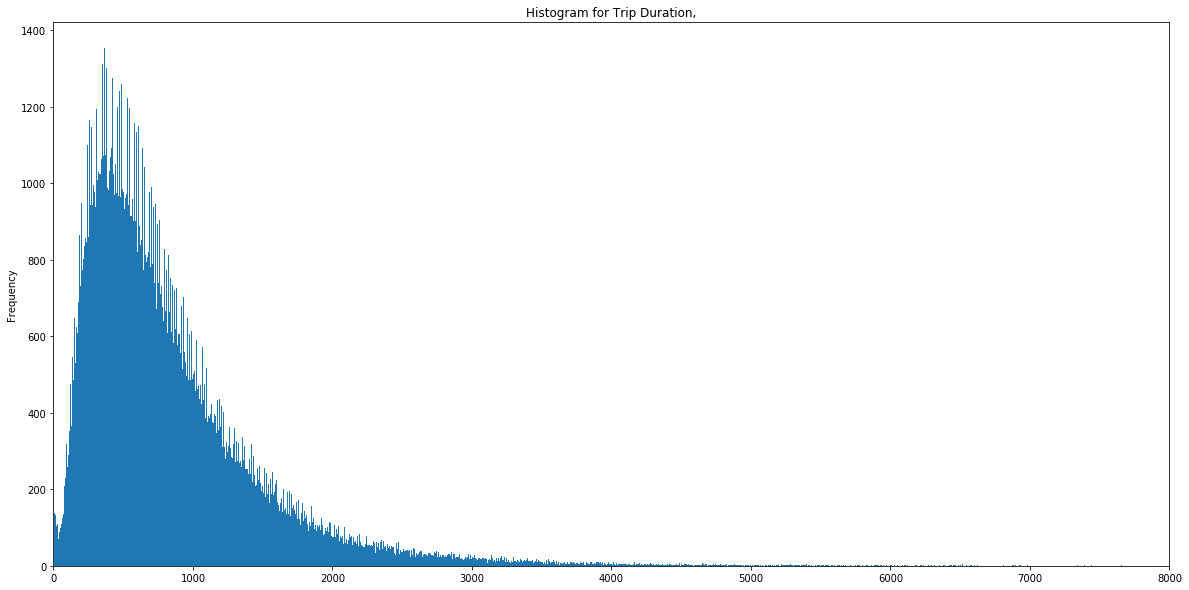

In [3]:
df['trip_duration'].plot.hist(figsize=(20,10),bins=20000,xlim=(0,8000),title='Histogram for Trip Duration,')

## Trajectories

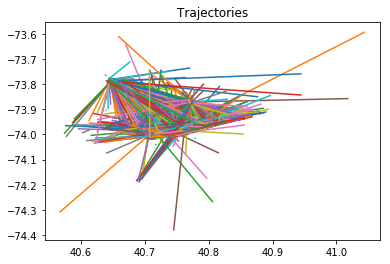

In [4]:
x1,x2=list(df['pickup_latitude']) , list(df['dropoff_latitude']) 
y1, y2 =list(df['pickup_longitude']) , list(df['dropoff_longitude'])
plt.clf()
for i in range(10000):
    plt.plot([x1[i],x2[i]],[y1[i],y2[i]])
plt.title('Trajectories')
plt.show()

## Pick up and drop off coordinates

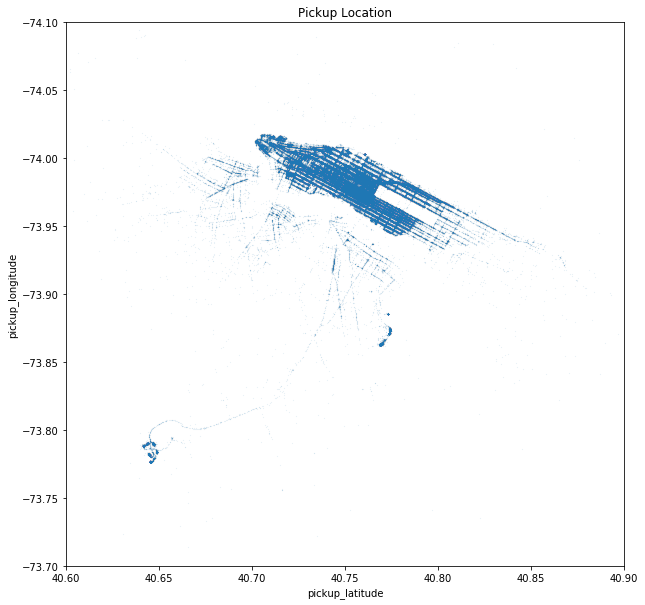

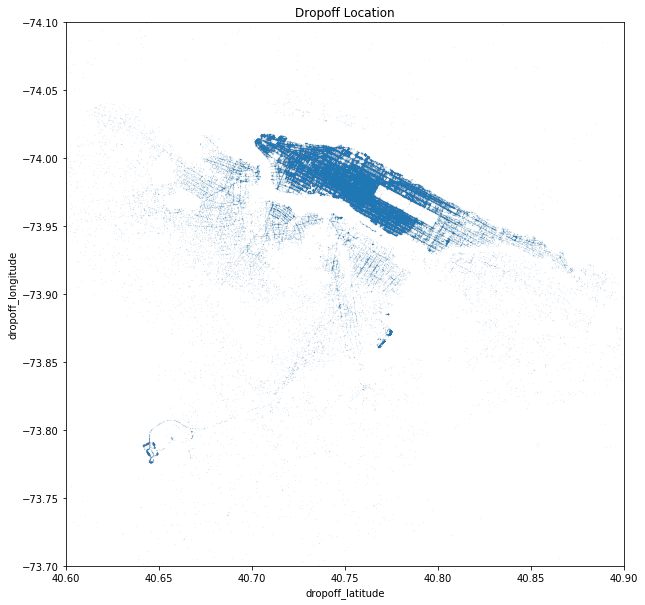

In [5]:
df.plot.scatter(y='pickup_longitude', x='pickup_latitude',figsize=(10,10),title='Pickup Location', s=0.001, xlim=(40.6,40.9),ylim=(-73.7,-74.1))
df.plot.scatter(y='dropoff_longitude', x='dropoff_latitude',figsize=(10,10),title='Dropoff Location', s=0.001, xlim=(40.6,40.9),ylim=(-73.7,-74.1))

## Pick up location clustering

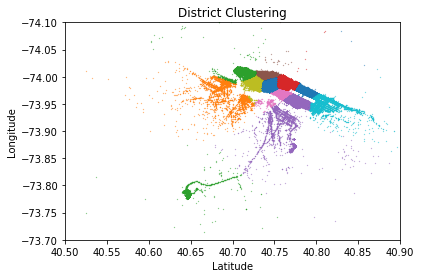

In [7]:
x = np.asarray(df['pickup_latitude'])
y = np.asarray(df['pickup_longitude'])
data=pd.DataFrame({'x':x,'y':y})
model = KMeans(n_clusters=15)
model.fit(data)
labels = pd.Series(model.predict(data),name='District')

data=pd.concat([data,labels],axis=1)
grouped = data.groupby(data['District'])

g=[grouped.get_group(i) for i in range(len(grouped))]
plt.clf()
for i in range(len(g)):
    plt.scatter(g[i].x,g[i].y,s=0.05)
plt.title('District Clustering')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.axis([40.5,40.9,-73.7,-74.1])
plt.show()

## Distances

In [8]:
df['Distance']=((df['dropoff_latitude']-df['pickup_latitude'])**2+(df['dropoff_longitude']-df['pickup_longitude'])**2)**0.5

## Days of week and hour of day

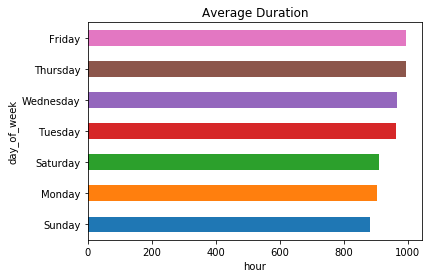

In [9]:
df['my_dates'] = pd.to_datetime(df['pickup_datetime'])

df['day_of_week'] = df['my_dates'].dt.weekday_name
grouped = df['trip_duration'].groupby(df['day_of_week'])
grouped.mean().sort_values().plot.barh(title='Average Duration')

df['hour'] = df['my_dates'].dt.hour
grouped = df['trip_duration'].groupby(df['hour'])
grouped.mean().plot(title='Average Duration')

## Vendor Time Series Graphs

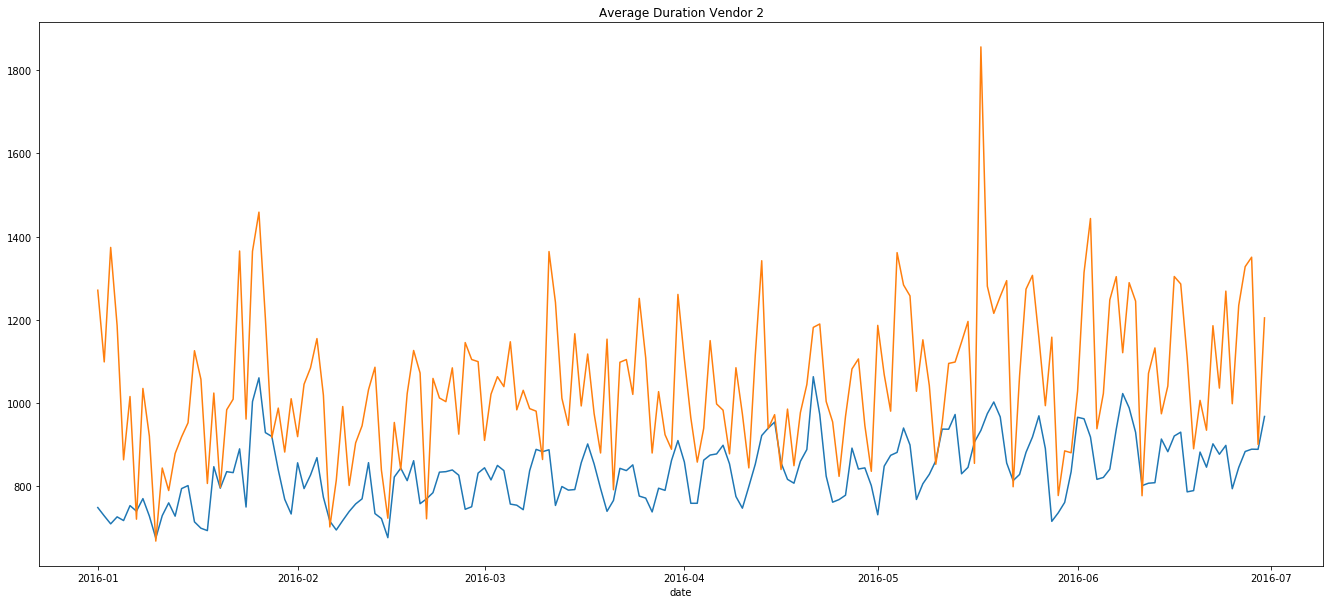

In [10]:
df['date'] = df['my_dates'].dt.date

grouped1 = df.query('vendor_id==1')['trip_duration'].groupby(df['date'])
grouped2 = df.query('vendor_id==2')['trip_duration'].groupby(df['date'])
plt.clf()
grouped1.mean().plot(figsize=(23,10),title='Average Duration Vendor 1',)
grouped2.mean().plot(figsize=(23,10),title='Average Duration Vendor 2')
plt.show()

# Stacking

In [11]:
daysofweek = pd.get_dummies(df['day_of_week'])
hour = pd.get_dummies(df['hour'])
vendor = pd.get_dummies(df['vendor_id'])
districts = pd.get_dummies(data['District'])

stacked=pd.concat([df['trip_duration'],df['Distance'], df['passenger_count'],daysofweek,hour,vendor,districts], axis=1,)

# Randomize, Assign lables, Split data into Training and Testing sets

In [12]:
stacked = stacked.sample(frac=1).reset_index(drop=True)

yList=list(stacked['trip_duration'])
del stacked['trip_duration']

xList=np.asarray(stacked)

xListTrain = [xList[i] for i in range(len(xList)) if i%4!=0]
xListTest = [xList[i] for i in range(len(xList)) if i%4==0]
yListTrain = [yList[i] for i in range(len(yList)) if i%4!=0]
yListTest = [yList[i] for i in range(len(yList)) if i%4==0]

# Modelling

In [21]:
for i in [500,750,1000,1250]:
    model = GradientBoostingRegressor(max_depth=1, n_estimators=i)
    model.fit(xListTrain,yListTrain)
    print('n_estimators = ' + str(i))
    print('\tTrain Score:\t', model.score(xListTrain,yListTrain))
    print('\tTest Score:\t', model.score(xListTest,yListTest))

n_estimators = 500
	Train Score:	 0.034755130024357817
	Test Score:	 0.03449202595350731
n_estimators = 750
	Train Score:	 0.03505157841491602
	Test Score:	 0.03466376321300202
n_estimators = 1000
	Train Score:	 0.035191937415290586
	Test Score:	 0.03466795141611334
n_estimators = 1250
	Train Score:	 0.03527866649361355
	Test Score:	 0.0346520138421772


In [22]:
for i in [500,750,1000,1250]:
    model = GradientBoostingRegressor(max_depth=2, n_estimators=i)
    model.fit(xListTrain,yListTrain)
    print('n_estimators = ' + str(i))
    print('\tTrain Score:\t', model.score(xListTrain,yListTrain))
    print('\tTest Score:\t', model.score(xListTest,yListTest))

n_estimators = 500
	Train Score:	 0.06283465275004452
	Test Score:	 0.03288473077205889
n_estimators = 750
	Train Score:	 0.097648299615964
	Test Score:	 0.02407354121359706
n_estimators = 1000
	Train Score:	 0.14078893060128772
	Test Score:	 0.008510468895009282
n_estimators = 1250
	Train Score:	 0.17720892540459032
	Test Score:	 -0.005529647612328992
